In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pd
from sklearn.metrics import r2_score

# Configuration

### Inputs

In [2]:
process_out_dir = '../../01_process/out/'
train_out_dir = '../../02_train/out/'

# data, primarily for the ice flags
train_data_fpath = process_out_dir + 'train_data.npz'
valid_data_fpath = process_out_dir + 'valid_data.npz'

### Values

In [3]:
# when deriving the max ice on date, one detail is that
# we must omit the late ice on dates that occur during a
# (predicted) rethaw. This value is a temporal index
# representing the maximum day after July 1 that can
# be a considered a max ice on date.
# A value of 215 equates to February 1
ice_on_cutoff = 215

# Use to contruct 1-day bins on the histogram from (-num, num)
n_days_hist_cutoff = 75


# Information needed to construct relevant filepaths
num_init = 5
pred_fpath_start = ['avg', 'large', 'massive']
model_names = ['lstm', 'transformer']


# Possibly fragile: sizes needed to store all preds together
seq_len = 365
train_n = 2178
valid_n = 722
n_epochs = 10000
n_compare = num_init*len(pred_fpath_start)*len(model_names)

# color guide
color_dict = {'avg lstm':'#1b9e77',
              'large lstm':'#7570b3',
              'massive lstm':'#66a61e',
              'avg transformer':'#d95f02',
              'large transformer':'#e7298a',
              'process-based':'#a6761d',
              'massive transformer':'#e6ab02',}

### Outputs

In [4]:
# Fragile: prepare to change if new results; this is a little qualitative atm so not automated
second_best_eval_metrics_fpath = '../out/avg_lstm_eval_metrics_3_.npz'
best_eval_metrics_fpath = '../out/massive_lstm_eval_metrics_1_.npz'

# Import data

In [5]:
# Import both development partitions
train_data = np.load(train_data_fpath, allow_pickle = True)
valid_data = np.load(valid_data_fpath, allow_pickle = True)

# Extract everything from training partition
train_x = train_data['x']
train_y = train_data['y']
train_dates = train_data['dates']
train_DOW = train_data['DOW']
train_variables = train_data['features']

# Extract everything from validation partition
valid_x = valid_data['x']
valid_y = valid_data['y']
valid_dates = valid_data['dates']
valid_DOW = valid_data['DOW']
valid_variables = valid_data['features']

In [6]:
# Objects to store data in
all_train_predictions = np.zeros([n_compare, train_n, seq_len, 1])
all_valid_predictions = np.zeros([n_compare, valid_n, seq_len, 1])
all_valid_loss_values = np.zeros([n_compare, n_epochs])

# Objects to store model info in
model_type_ls = []
model_size_ls = []
model_init_ls = []
model_ran_epochs_ls = [] # for plotting and storing variable len w.r.t. early stopping

count = 0
for model_type in model_names:
    for model_size in pred_fpath_start:
        for i in range(num_init):
            # store relevant info
            model_type_ls.append(model_type)
            model_size_ls.append(model_size)
            model_init_ls.append(i)
            
            # construct the filepaths for both partition's predictions and the associated loss curves
            train_pred_file = train_out_dir + model_size + '_' + model_type + '_train_preds_' + str(i) + '_.npy'
            valid_pred_file = train_out_dir + model_size + '_' + model_type + '_valid_preds_' + str(i) + '_.npy'
            loss_file = train_out_dir + model_size + '_' + model_type + '_loss_lists_' + str(i) + '_.npz'
            
            # load
            train_predictions = np.load(train_pred_file)
            valid_predictions = np.load(valid_pred_file)
            valid_loss_values = np.load(loss_file, allow_pickle=True)['valid_loss']
            
            # update true epochs for this model run w.r.t. early stopping
            ran_epochs = len(valid_loss_values)
            model_ran_epochs_ls.append(ran_epochs)
            
            # store data
            all_train_predictions[count] = train_predictions
            all_valid_predictions[count] = valid_predictions
            all_valid_loss_values[count, :ran_epochs] = valid_loss_values
    
            count += 1

In [7]:
# Programmatically identify process-based ice flag data
ice_var_idx = int(np.argwhere(train_variables == 'ice'))
assert valid_variables[ice_var_idx] == 'ice'

# View loss curves

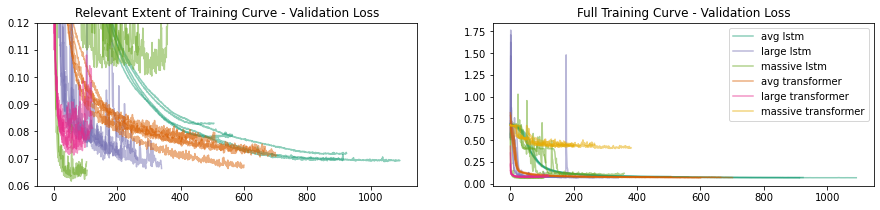

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (15, 3))

# Plot all curves
for i in range(n_compare):
    # Label accordingly
    name = model_size_ls[i] + ' ' + model_type_ls[i]
    ax[0].plot(all_valid_loss_values[i][:model_ran_epochs_ls[i]],
               alpha = 0.5, color = color_dict[name])
# Zoom in to the extent that matters
ax[0].set_ylim(0.06, 0.12)
# Further labeling
ax[0].set_title('Relevant Extent of Training Curve - Validation Loss')

# Plot all curves
for i in range(n_compare):
    name = model_size_ls[i] + ' ' + model_type_ls[i]
    ax[1].plot(all_valid_loss_values[i][:model_ran_epochs_ls[i]],
               alpha = 0.5, label = name, color = color_dict[name])
# Handling redundant legend labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[1].legend(by_label.values(), by_label.keys())
# Further labeling
ax[1].set_title('Full Training Curve - Validation Loss');

# Start a pandas dataframe to store relevant information in

In [9]:
name_ls = []
min_pred_prob = []
max_pred_prob = []

for i in range(n_compare):
    # Label accordingly
    name = model_size_ls[i] + ' ' + model_type_ls[i]
    cur_valid_predictions = all_valid_predictions[i]
    
    name_ls.append(name)
    min_pred_prob.append(cur_valid_predictions.min())
    max_pred_prob.append(cur_valid_predictions.max())
    
eval_df = pd.DataFrame({'name':name_ls, 'min_pred_prob':min_pred_prob, 'max_pred_prob':max_pred_prob})
eval_df

,name,min_pred_prob,max_pred_prob
0,avg lstm,6.289064e-03,0.987399
1,avg lstm,4.253939e-03,0.990116
2,avg lstm,1.044267e-03,0.997387
3,avg lstm,1.895032e-03,0.996763
4,avg lstm,2.027355e-03,0.996593
5,large lstm,8.235758e-06,0.999873
6,large lstm,3.658706e-06,0.999802
7,large lstm,8.103283e-05,0.999910
8,large lstm,5.805307e-06,0.999968
9,large lstm,1.330446e-05,0.999879


# Convert predicted probabilities into predicted class (ice or not)

In [10]:
all_train_predictions_class = np.round(all_train_predictions)
all_valid_predictions_class = np.round(all_valid_predictions)

# Ditch massive transformers

Their poor convergence results in very low predicted probabilities that breaks the rest of the code (i.e., they never predict ice)

In [11]:
n_compare += -5 # get rid of massive transformer results that break code

eval_df = eval_df.iloc[:-5, :].copy()

# Overall accuracy

Including quick check on overfitting

In [12]:
def calc_accuracy(pred_probs, obs):
    # Here, the 0-index is just getting rid of the feature
    # dimension of the (originally) pytorch prediction object
    flat_preds = pred_probs[:, :, 0].flatten()
    flat_obs = obs.flatten()
    
    return np.sum(flat_preds == flat_obs) / flat_obs.shape[0]
    
assert train_variables[ice_var_idx] == valid_variables[ice_var_idx] == 'ice'

def calc_accuracy_iceflags(inputs, obs):
    
    flat_ice_flags = inputs[:, :, ice_var_idx].flatten()
    flat_obs = obs.flatten()
    
    return np.sum(flat_ice_flags == flat_obs) / flat_obs.shape[0]

In [13]:
# TO DO: add PB ice flag
train_accuracy_ls = []
valid_accuracy_ls = []

# get accuracy for each model
for i in range(n_compare):
    train_accuracy = calc_accuracy(all_train_predictions_class[i], train_y)
    valid_accuracy = calc_accuracy(all_valid_predictions_class[i], valid_y)
    
    train_accuracy_ls.append(train_accuracy)
    valid_accuracy_ls.append(valid_accuracy)

# store accuracy
eval_df['train_accuracy'] = train_accuracy_ls
eval_df['valid_accuracy'] = valid_accuracy_ls

# Error of predicted ice on/off dates

### Derive predicted max ice on and max ice off dates

In [14]:
def extract_date_i_and_date(ice_indications, dates):
    
    # ice_on_cutoff is globally defined
    
    ice_on_ids = []
    ice_off_ids = []
    
    ice_on = []
    ice_off = []

    for i in range(ice_indications.shape[0]):
        # Result in +1 when ice emerges and -1 when ice disappears. 0 otherwise.
        diff_i = np.diff(ice_indications[i, :])

        # Indexing by -1 finds the latest/"max" occurrence
        # for ice_on, we need to avoid late season refreeze ice on dates
        ice_on_index = np.argwhere(diff_i == 1)[np.argwhere(diff_i == 1) < ice_on_cutoff][-1].item()
        ice_off_index = np.argwhere(diff_i == -1)[-1].item()

        # Store found indices
        ice_on_ids.append(ice_on_index)
        ice_off_ids.append(ice_off_index)
        
        # Store found dates
        ice_on.append(dates[i, ice_on_index])
        ice_off.append(dates[i, ice_off_index])
        
    return(ice_on_ids, ice_off_ids,
           ice_on, ice_off)

In [15]:
# important dates = last ice on and last ice off
# get important dates and date-indices for observations
objects = extract_date_i_and_date(valid_y, valid_dates)
obs_ice_on_ids, obs_ice_off_ids, obs_ice_on, obs_ice_off = objects

In [16]:
# get important dates and date-indices for process-based ice flag
objects = extract_date_i_and_date(valid_x[:, :, ice_var_idx], valid_dates)
flag_ice_on_ids, flag_ice_off_ids, flag_ice_on, flag_ice_off = objects

In [17]:
# get important dates and date-indices for all models
all_pred_ice_on_ids = np.zeros([n_compare, valid_n])
all_pred_ice_off_ids = np.zeros([n_compare, valid_n])
all_pred_ice_on = np.zeros([n_compare, valid_n]).astype(str)
all_pred_ice_off = np.zeros([n_compare, valid_n]).astype(str)

for i in range(n_compare):
    objects = extract_date_i_and_date(all_valid_predictions_class[i, :, :, 0], valid_dates)
    pred_ice_on_ids, pred_ice_off_ids, pred_ice_on, pred_ice_off = objects
    
    all_pred_ice_on_ids[i] = pred_ice_on_ids
    all_pred_ice_off_ids[i] = pred_ice_off_ids
    all_pred_ice_on[i] = pred_ice_on
    all_pred_ice_off[i] = pred_ice_off

### Define some functions to deal with those dates

In [18]:
def calc_date_errors(pred_dates, obs_dates):
    # convert obj/str dates into datetimes
    formatted_obs_dates = np.asarray(obs_dates).astype(np.datetime64)
    formatted_pred_dates = np.asarray(pred_dates).astype(np.datetime64)
    
    # calc simple difference
    pred_errors = formatted_obs_dates - formatted_pred_dates
    
    # convert datetime difference to int (days)
    pred_errors = pred_errors.astype(int)
    
    return pred_errors

# simple RMSE calculation
def calc_rmse(errors):
    return np.sqrt(np.sum(errors**2) / len(errors))

### Errors for ice on

In [19]:
# calculate all errors: obs - pred
all_pred_ice_on_error = np.zeros([n_compare, valid_n])

for i in range(n_compare):
    all_pred_ice_on_error[i] = calc_date_errors(all_pred_ice_on[i], obs_ice_on)
    
# PB flag
flag_ice_on_error = calc_date_errors(flag_ice_on, obs_ice_on)

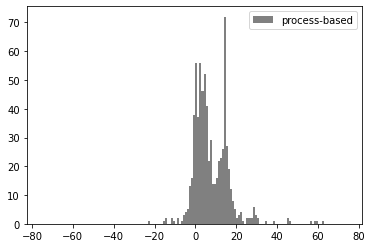

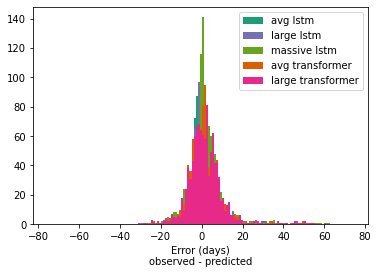

In [20]:
# view distribution of errors
plt.hist(flag_ice_on_error, label = 'process-based',
         bins = range(-1*n_days_hist_cutoff, n_days_hist_cutoff), color = 'gray')
plt.legend()
plt.pause(0.001)

for i in range(n_compare):
    name = model_size_ls[i] + ' ' + model_type_ls[i]
    plt.hist(all_pred_ice_on_error[i], 
             bins = range(-1*n_days_hist_cutoff, n_days_hist_cutoff),
             label = name, color = color_dict[name])
# Handling redundant legend labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel('Error (days)\nobserved - predicted');

In [21]:
# calculate average of errors and RMSE
ice_on_avg_error = []
ice_on_rmse = []

for i in range(n_compare):
    
    avg_error = np.mean(all_pred_ice_on_error[i])
    rmse = calc_rmse(all_pred_ice_on_error[i])
    
    ice_on_avg_error.append(avg_error)
    ice_on_rmse.append(rmse)

# store in dataframe
eval_df['ice_on_avg_error'] = ice_on_avg_error
eval_df['ice_on_rmse'] = ice_on_rmse

### Errors for ice off

In [22]:
# calculate all errors: obs - pred
all_pred_ice_off_error = np.zeros([n_compare, valid_n])

for i in range(n_compare):
    all_pred_ice_off_error[i] = calc_date_errors(all_pred_ice_off[i], obs_ice_off)
    
# PB flag
flag_ice_off_error = calc_date_errors(flag_ice_off, obs_ice_off)

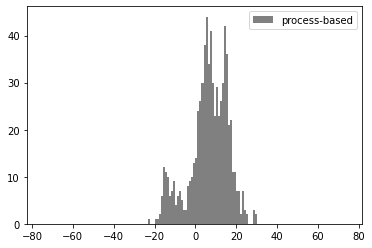

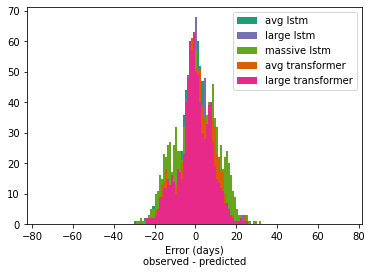

In [23]:
# view distribution of errors
plt.hist(flag_ice_off_error, label = 'process-based',
         bins = range(-1*n_days_hist_cutoff, n_days_hist_cutoff), color = 'gray')
plt.legend()
plt.pause(0.001)

for i in range(n_compare):
    name = model_size_ls[i] + ' ' + model_type_ls[i]
    plt.hist(all_pred_ice_off_error[i], 
             bins = range(-1*n_days_hist_cutoff, n_days_hist_cutoff),
             label = name, color = color_dict[name])
# Handling redundant legend labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel('Error (days)\nobserved - predicted');

In [24]:
# calculate average of errors and RMSE
ice_off_avg_error = []
ice_off_rmse = []

for i in range(n_compare):
    
    avg_error = np.mean(all_pred_ice_off_error[i])
    rmse = calc_rmse(all_pred_ice_off_error[i])
    
    ice_off_avg_error.append(avg_error)
    ice_off_rmse.append(rmse)
    
# store in dataframe
eval_df['ice_off_avg_error'] = ice_off_avg_error
eval_df['ice_off_rmse'] = ice_off_rmse

### Error for predicted ice duration

In [25]:
# Simply take number of days between ice on and ice off for ice duration
def calc_ice_duration(off, on):
    dur = np.asarray(off).astype(np.datetime64) - np.asarray(on).astype(np.datetime64)
    return dur.astype(int)

In [26]:
ice_dur_avg_error = []
ice_dur_rmse = []

for i in range(n_compare):
    
    obs_dur = calc_ice_duration(obs_ice_off, obs_ice_on)
    pred_dur = calc_ice_duration(all_pred_ice_off[i], all_pred_ice_on[i])

    # error
    pred_error_dur = obs_dur - pred_dur
    
    # average error and rmse
    ice_dur_avg_error.append(np.mean(pred_error_dur))
    ice_dur_rmse.append(calc_rmse(pred_error_dur))
    
# PB ice flag
flag_dur = calc_ice_duration(flag_ice_off, flag_ice_on)
flag_error_dur = obs_dur - flag_dur
    
# store
eval_df['ice_dur_avg_error'] = ice_dur_avg_error
eval_df['ice_dur_rmse'] = ice_dur_rmse

# Add process-based ice flag evaluation to the dataframe

In [27]:
new_row = ['process-based', 0, 1,
 calc_accuracy(train_x[:, :, [ice_var_idx]], train_y),
 calc_accuracy(valid_x[:, :, [ice_var_idx]], valid_y),
 np.mean(flag_ice_on_error),
 calc_rmse(flag_ice_on_error),
 np.mean(flag_ice_off_error),
 calc_rmse(flag_ice_off_error),
 np.mean(flag_error_dur),
 calc_rmse(flag_error_dur)]

eval_df.loc[len(eval_df)] = new_row

# Find model that improved upon PB baseline the best (and second best)

As determined by average reduction in ice on, ice off, and ice duration RMSE

In [28]:
# get indices of date-based RMSEs in dataframe
col_names_as_array = np.asarray(list(eval_df))
i1 = np.argwhere(col_names_as_array == 'ice_on_rmse').item()
i2 = np.argwhere(col_names_as_array == 'ice_off_rmse').item()
i3 = np.argwhere(col_names_as_array == 'ice_dur_rmse').item()

# get the percent change in RMSEs relative to PB ice flags
perc_change_rmse = (eval_df.iloc[:, [i1, i2, i3]] - eval_df.iloc[-1, [i1, i2, i3]]) / eval_df.iloc[-1, [i1, i2, i3]]

# average percent change across the 3 columns
eval_df['avg_rmse_change'] = np.mean(perc_change_rmse.values, axis = 1)

In [29]:
# rank all model realizations by their avg rmse improvement
temp = eval_df['avg_rmse_change'].values.argsort()
ranks = np.empty_like(temp)
ranks[temp] = np.arange(len(eval_df['avg_rmse_change'].values))
eval_df['avg_rmse_change_rank'] = ranks

In [30]:
best_i = np.argsort(eval_df['avg_rmse_change'])[0]
second_best_i = np.argsort(eval_df['avg_rmse_change'])[1]

In [31]:
# display full eval_df
eval_df

,name,min_pred_prob,max_pred_prob,train_accuracy,valid_accuracy,ice_on_avg_error,ice_on_rmse,ice_off_avg_error,ice_off_rmse,ice_dur_avg_error,ice_dur_rmse,avg_rmse_change,avg_rmse_change_rank
0,avg lstm,6.289064e-03,0.987399,0.973695,0.970770,-0.596953,7.174613,-0.182825,8.291270,0.414127,11.758477,-0.289336,19
1,avg lstm,4.253939e-03,0.990116,0.975375,0.971187,-0.437673,6.867564,0.167590,8.032741,0.605263,10.580846,-0.331721,10
2,avg lstm,1.044267e-03,0.997387,0.977260,0.974371,-0.634349,6.456331,-0.127424,7.347715,0.506925,9.796404,-0.381037,2
3,avg lstm,1.895032e-03,0.996763,0.976888,0.974614,-0.299169,6.475182,-0.155125,7.333942,0.144044,9.789474,-0.381043,1
4,avg lstm,2.027355e-03,0.996593,0.977356,0.973483,-0.076177,6.800786,0.216066,7.380629,0.292244,10.140358,-0.362476,5
5,large lstm,8.235758e-06,0.999873,0.974096,0.973271,-1.177285,6.751834,0.500000,7.826105,1.677285,10.763447,-0.337156,7
6,large lstm,3.658706e-06,0.999802,0.975556,0.974189,-0.642659,6.605211,-0.578947,7.411902,0.063712,9.941937,-0.371617,4
7,large lstm,8.103283e-05,0.999910,0.971101,0.971582,-0.123269,7.443136,0.637119,7.033950,0.760388,11.263711,-0.329267,11
8,large lstm,5.805307e-06,0.999968,0.973246,0.972853,-0.590028,6.775996,-1.688366,7.801644,-1.098338,10.847150,-0.335332,9
9,large lstm,1.330446e-05,0.999879,0.973628,0.972971,-0.887812,6.858179,-0.526316,7.614500,0.361496,10.715989,-0.341306,6


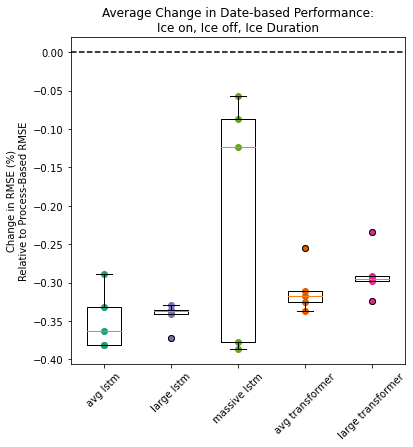

In [32]:
# models to plot (dropping process-based)
focal_models = ['avg lstm', 'large lstm', 'massive lstm', 'avg transformer', 'large transformer']

# creating a new dataframe for easier boxplot plotting
avg_rmse_change_df = pd.DataFrame({'avg lstm':eval_df[eval_df['name'] == 'avg lstm']['avg_rmse_change'].astype(float).values})
# every model is a column
avg_rmse_change_df['large lstm'] = eval_df[eval_df['name'] == 'large lstm']['avg_rmse_change'].astype(float).values
avg_rmse_change_df['massive lstm'] = eval_df[eval_df['name'] == 'massive lstm']['avg_rmse_change'].astype(float).values
avg_rmse_change_df['avg transformer'] = eval_df[eval_df['name'] == 'avg transformer']['avg_rmse_change'].astype(float).values
avg_rmse_change_df['large transformer'] = eval_df[eval_df['name'] == 'large transformer']['avg_rmse_change'].astype(float).values


# Start plotting
plt.figure(figsize = (6, 6))

# add 0-line reference representing no improvement over process-based
plt.axhline(0, color = 'black', linestyle = '--')
# add boxplot for conveniance, note: low n (5)
plt.boxplot(avg_rmse_change_df[focal_models]);

# plot individual performances
count = 1
last_name = eval_df['name'][count]
for i in range(n_compare):
    cur_name = eval_df['name'][i]
    if cur_name != last_name:
        count += 1
        last_name = eval_df['name'][i]
    plt.scatter(count, eval_df['avg_rmse_change'][i], color = color_dict[eval_df['name'][i]])
    
# extra formatting
plt.ylabel('Change in RMSE (%)\nRelative to Process-Based RMSE')
plt.title('Average Change in Date-based Performance:\nIce on, Ice off, Ice Duration')
plt.xticks(range(1,6), focal_models, rotation = 45);

The best `massive lstm` performed best, but `massive lstm`s, in general, were a less reliable training set up.

The 2nd best model was an `avg lstm`. This set up is common and was more consistent than the `massive lstm`s.

Both will be examined with XAI methods.

# Final, subset view of df

In [33]:
eval_df.iloc[[best_i, second_best_i, -1]]

,name,min_pred_prob,max_pred_prob,train_accuracy,valid_accuracy,ice_on_avg_error,ice_on_rmse,ice_off_avg_error,ice_off_rmse,ice_dur_avg_error,ice_dur_rmse,avg_rmse_change,avg_rmse_change_rank
11,massive lstm,0.000018,0.999693,0.976831,0.975225,-0.076177,6.542531,0.321330,7.042609,0.397507,9.857362,-0.386141,0
3,avg lstm,0.001895,0.996763,0.976888,0.974614,-0.299169,6.475182,-0.155125,7.333942,0.144044,9.789474,-0.381043,1
25,process-based,0.000000,1.000000,0.955436,0.951011,7.314404,11.427660,6.168975,11.355743,-1.145429,15.191346,0.0,25


# Save these calculcated errors

In [34]:
# Batch all these calculated errors together
evals1 = {'flag_error_ice_on':flag_ice_on_error,
          'flag_error_ice_off':flag_ice_off_error,
          'flag_error_dur':flag_error_dur,
          'pred_error_ice_on':all_pred_ice_on_error[best_i],
          'pred_error_ice_off':all_pred_ice_off_error[best_i],
          'pred_error_dur':obs_dur - calc_ice_duration(all_pred_ice_off[best_i],
                                                       all_pred_ice_on[best_i]),
          'model_name_ls':eval_df['name'][best_i]}

In [35]:
np.savez_compressed(best_eval_metrics_fpath, **evals1)

In [36]:
# Batch all these calculated errors together
evals2 = {'flag_error_ice_on':flag_ice_on_error,
          'flag_error_ice_off':flag_ice_off_error,
          'flag_error_dur':flag_error_dur,
          'pred_error_ice_on':all_pred_ice_on_error[best_i],
          'pred_error_ice_off':all_pred_ice_off_error[best_i],
          'pred_error_dur':obs_dur - calc_ice_duration(all_pred_ice_off[best_i],
                                                       all_pred_ice_on[best_i]),
          'model_name_ls':eval_df['name'][best_i]}

In [37]:
np.savez_compressed(second_best_eval_metrics_fpath, **evals2)

<br><br><br><br><br>

# Additional recommended plots

I'm doing these in the evaluation metrics notebook instead of the plotting notebook because they are related to higher level prediction targets considered here, rather than evaluating residuals, which is the primary focus of the other notebook.

### Scatter plots of observations versus predictions

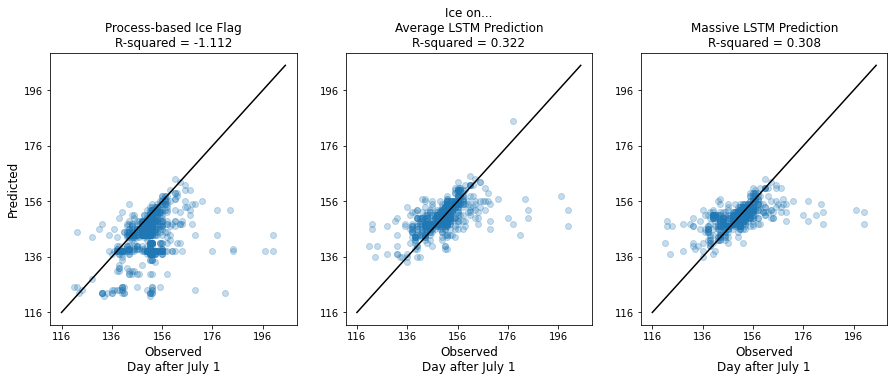

In [38]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

# Determine a shared lower and upper lim for 1:1 plot
lower_lim = min([min(obs_ice_on_ids),
                 min(flag_ice_on_ids), 
                 min(all_pred_ice_on_ids[best_i]),
                 min(all_pred_ice_on_ids[second_best_i])]) - 5
upper_lim = max([max(obs_ice_on_ids),
                 max(flag_ice_on_ids),
                 max(all_pred_ice_on_ids[best_i]),
                 max(all_pred_ice_on_ids[second_best_i])]) + 5

# Calculate corr
cor_flag = np.round(r2_score(obs_ice_on_ids, flag_ice_on_ids), 3)
cor_pred_sec_best = np.round(r2_score(obs_ice_on_ids, all_pred_ice_on_ids[second_best_i]), 3)
cor_pred_best = np.round(r2_score(obs_ice_on_ids, all_pred_ice_on_ids[best_i]), 3)

# Actual plotting
ax[0].scatter(obs_ice_on_ids, flag_ice_on_ids, alpha = 0.25)
ax[1].scatter(obs_ice_on_ids, all_pred_ice_on_ids[second_best_i], alpha = 0.25)
ax[2].scatter(obs_ice_on_ids, all_pred_ice_on_ids[best_i], alpha = 0.25)

# All the labels
#fig.suptitle('Ice on', fontsize = 14)
ax[0].set_ylabel('Predicted', fontsize = 12)
ax[0].set_title('Process-based Ice Flag\nR-squared = ' + str(cor_flag), fontsize = 12)
ax[1].set_title('Ice on...\nAverage LSTM Prediction\nR-squared = ' + str(cor_pred_sec_best), fontsize = 12)
ax[2].set_title('Massive LSTM Prediction\nR-squared = ' + str(cor_pred_best), fontsize = 12)

# some formating for all plots
for i in range(3):
    ax[i].set_xlabel('Observed\nDay after July 1', fontsize = 12)
    ax[i].plot([lower_lim, upper_lim], [lower_lim, upper_lim], color = 'black')
    ax[i].set_xticks(np.arange(lower_lim, upper_lim, 20))
    ax[i].set_yticks(np.arange(lower_lim, upper_lim, 20));

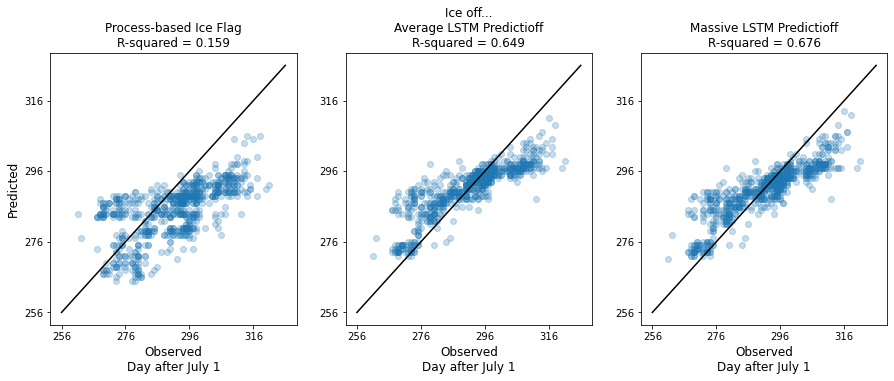

In [39]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

# Determine a shared lower and upper lim for 1:1 plot
lower_lim = min([min(obs_ice_off_ids),
                 min(flag_ice_off_ids), 
                 min(all_pred_ice_off_ids[best_i]),
                 min(all_pred_ice_off_ids[second_best_i])]) - 5
upper_lim = max([max(obs_ice_off_ids),
                 max(flag_ice_off_ids),
                 max(all_pred_ice_off_ids[best_i]),
                 max(all_pred_ice_off_ids[second_best_i])]) + 5

# Calculate corr
cor_flag = np.round(r2_score(obs_ice_off_ids, flag_ice_off_ids), 3)
cor_pred_sec_best = np.round(r2_score(obs_ice_off_ids, all_pred_ice_off_ids[second_best_i]), 3)
cor_pred_best = np.round(r2_score(obs_ice_off_ids, all_pred_ice_off_ids[best_i]), 3)

# Actual plotting
ax[0].scatter(obs_ice_off_ids, flag_ice_off_ids, alpha = 0.25)
ax[1].scatter(obs_ice_off_ids, all_pred_ice_off_ids[second_best_i], alpha = 0.25)
ax[2].scatter(obs_ice_off_ids, all_pred_ice_off_ids[best_i], alpha = 0.25)

# All the labels
#fig.suptitle('Ice off', fontsize = 14)
ax[0].set_ylabel('Predicted', fontsize = 12)
ax[0].set_title('Process-based Ice Flag\nR-squared = ' + str(cor_flag), fontsize = 12)
ax[1].set_title('Ice off...\nAverage LSTM Predictioff\nR-squared = ' + str(cor_pred_sec_best), fontsize = 12)
ax[2].set_title('Massive LSTM Predictioff\nR-squared = ' + str(cor_pred_best), fontsize = 12)

# some formating for all plots
for i in range(3):
    ax[i].set_xlabel('Observed\nDay after July 1', fontsize = 12)
    ax[i].plot([lower_lim, upper_lim], [lower_lim, upper_lim], color = 'black')
    ax[i].set_xticks(np.arange(lower_lim, upper_lim, 20))
    ax[i].set_yticks(np.arange(lower_lim, upper_lim, 20));

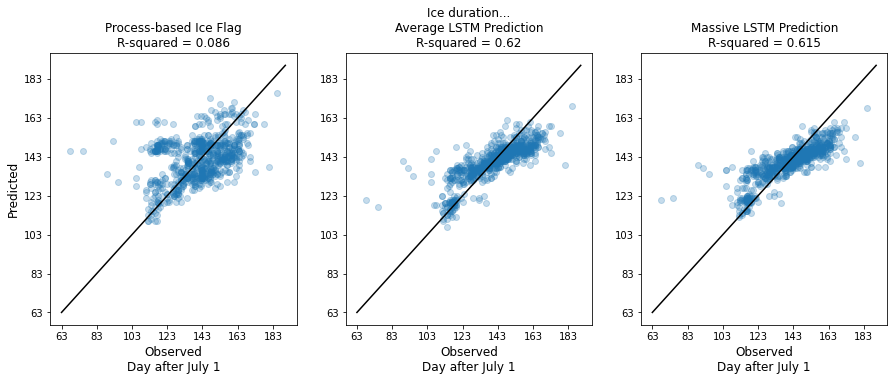

In [40]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

second_best_model_ice_dur = calc_ice_duration(all_pred_ice_off[second_best_i],
                                              all_pred_ice_on[second_best_i])
best_model_ice_dur = calc_ice_duration(all_pred_ice_off[best_i],
                                       all_pred_ice_on[best_i])

# Determine a shared lower and upper lim for 1:1 plot
lower_lim = min([min(obs_dur),
                 min(flag_dur), 
                 min(second_best_model_ice_dur),
                 min(best_model_ice_dur)]) - 5
upper_lim = max([max(obs_dur),
                 max(flag_dur),
                 max(second_best_model_ice_dur),
                 max(best_model_ice_dur)]) + 5

# Calculate corr
cor_flag = np.round(r2_score(obs_dur, flag_dur), 3)
cor_pred_sec_best = np.round(r2_score(obs_dur, second_best_model_ice_dur), 3)
cor_pred_best = np.round(r2_score(obs_dur, best_model_ice_dur), 3)

# Actual plotting
ax[0].scatter(obs_dur, flag_dur, alpha = 0.25)
ax[1].scatter(obs_dur, second_best_model_ice_dur, alpha = 0.25)
ax[2].scatter(obs_dur, best_model_ice_dur, alpha = 0.25)

# All the labels
#fig.suptitle('Ice Off', fontsize = 14)
ax[0].set_ylabel('Predicted', fontsize = 12)
ax[0].set_title('Process-based Ice Flag\nR-squared = ' + str(cor_flag), fontsize = 12)
ax[1].set_title('Ice duration...\nAverage LSTM Prediction\nR-squared = ' + str(cor_pred_sec_best), fontsize = 12)
ax[2].set_title('Massive LSTM Prediction\nR-squared = ' + str(cor_pred_best), fontsize = 12)

# some formating for all plots
for i in range(3):
    ax[i].set_xlabel('Observed\nDay after July 1', fontsize = 12)
    ax[i].plot([lower_lim, upper_lim], [lower_lim, upper_lim], color = 'black')
    ax[i].set_xticks(np.arange(lower_lim, upper_lim, 20))
    ax[i].set_yticks(np.arange(lower_lim, upper_lim, 20));